In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import seaborn as sns


In [2]:
# ======================
# 1. Data Preparation
# ======================
def load_data():

    print("Downloading Google data...")
    data = yf.download("GOOGL", start='2015-01-01', end='2025-01-01')
    data = data.copy()
    data.loc[:, "LogReturn"] = np.log(data["Close"] / data["Close"].shift(1))
    return data.dropna()




In [3]:

# ======================
# 2. Core Algorithm (Enhanced)
# ======================
def trend_augmented_distance(w1, w2):
    """Enhanced Wasserstein distance with trend component"""
    base_dist = wasserstein_distance(w1, w2)
    trend_diff = np.abs(np.sum(w1) - np.sum(w2)) * 0.3  # Weighted trend difference
    return base_dist + trend_diff

def compute_wasserstein_matrix(windows):
    """Compute normalized Wasserstein distance matrix with trend augmentation"""
    n = len(windows)
    dist_matrix = np.zeros((n, n))
    
    for i in tqdm(range(n), desc="Computing Wasserstein distances"):
        for j in range(i, n):
            if len(windows[i]) == 0 or len(windows[j]) == 0:
                dist_matrix[i,j] = np.inf
            else:
                try:
                    dist = trend_augmented_distance(windows[i], windows[j])
                    dist_matrix[i,j] = dist if not np.isnan(dist) else np.inf
                except:
                    dist_matrix[i,j] = np.inf
            dist_matrix[j,i] = dist_matrix[i,j]
    
    max_finite = np.max(dist_matrix[np.isfinite(dist_matrix)], initial=1.0)
    dist_matrix[~np.isfinite(dist_matrix)] = 10 * max_finite
    return dist_matrix / np.max(dist_matrix)


def detect_regimes(data, window_size=126, n_clusters=3):
    """Main regime detection function"""
    returns = data["LogReturn"].values
    windows = [returns[i:i+window_size] for i in range(len(returns)-window_size)]
    
    dist_matrix = compute_wasserstein_matrix(windows)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(dist_matrix)
    regimes = kmeans.labels_
    
    # Label clusters based on characteristics
    cluster_stats = []
    for i in range(n_clusters):
        cluster_returns = [windows[j] for j in range(len(windows)) if regimes[j] == i]
        cumulative_return = np.mean([np.sum(r) for r in cluster_returns])  # Sum of returns
        mean_vol = np.mean([np.std(r) for r in cluster_returns])
        cluster_stats.append((cumulative_return, mean_vol))
    
    # Sort by cumulative return (not mean return)
    sorted_clusters = np.argsort([stat[0] for stat in cluster_stats])[::-1]
    
    # Initialize labels as Sideways by default
    regime_labels = np.array(["Sideways"] * len(regimes))
    
    # Assign Bull and Bear labels to the top and bottom clusters
    regime_labels[regimes == sorted_clusters[0]] = "Bull"
    regime_labels[regimes == sorted_clusters[-1]] = "Bear"
    
    # Post-processing thresholds
    for i in range(len(regime_labels)):
        total_return = np.sum(windows[i])
        if total_return > 0.15:  # Strong Bull threshold (15%+ cumulative)
            regime_labels[i] = "Bull"
        elif total_return < -0.15:  # Strong Bear threshold (-15%+ cumulative)
            regime_labels[i] = "Bear"
        elif -0.05 <= total_return <= 0.05:  # Explicit Sideways range
            regime_labels[i] = "Sideways"
    
    return regime_labels, windows, dist_matrix

In [4]:

# ======================
# 3. Visualization (Unchanged)
# ======================
def plot_regime_results(data, regime_labels, window_size):
    """Create price and returns plots with regime shading"""
    dates = data.index.to_numpy()
    price = data["Close"].values
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})
    
    # Price plot
    ax1.plot(dates, price, color='black', lw=1)
    colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'gray'}
    for i, label in enumerate(regime_labels):
        start = dates[i]
        end = dates[i + window_size]
        ax1.axvspan(start, end, color=colors[label], alpha=0.1)
    ax1.set_title(f"{data.index.name} with {window_size}-Day Regimes", fontsize=14)
    ax1.set_ylabel("Price", fontsize=12)
    
    # Returns plot
    for i, label in enumerate(regime_labels):
        start = i + window_size
        end = start + 1 if i < len(regime_labels)-1 else len(data)
        ax2.scatter(dates[start:end], data["LogReturn"].iloc[start:end], 
                   color=colors[label], s=5, alpha=0.5, label=label if i == 0 else "")
    ax2.set_title("Daily Log Returns by Regime", fontsize=14)
    ax2.set_ylabel("Log Returns", fontsize=12)
    
    # Formatting
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.grid(True, linestyle='--', alpha=0.5)
    ax2.legend()
    plt.tight_layout()
    plt.savefig(f'regimes_{window_size}days.png', dpi=300, bbox_inches='tight')
    plt.show()




In [9]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import pandas as pd

def process_single_run(data_subset, h1, h2):
    """Process one hyperparameter combination run in parallel"""
    try:
        offset = np.random.randint(0, h2)
        windows = [data_subset["LogReturn"].iloc[offset+i:offset+i+h1].values 
                  for i in range(0, len(data_subset)-h1-offset, h2)]
        
        if len(windows) < 4:  # Minimum windows for meaningful clustering
            return None
            
        dist_matrix = compute_wasserstein_matrix(windows)
        kmeans = KMeans(n_clusters=3).fit(dist_matrix)
        
        # Calculate validation metrics
        centroids = [windows[np.argmin(c)] for c in kmeans.cluster_centers_]
        inter_dists = [trend_augmented_distance(centroids[i], centroids[j]) 
                      for i in range(3) for j in range(i+1, 3)]
        avg_inter_dist = np.mean(inter_dists)
        
        # Try silhouette score, fallback to normalized distance
        try:
            sil_score = silhouette_score(dist_matrix, kmeans.labels_)
        except:
            sil_score = avg_inter_dist / np.mean(dist_matrix)
            
        return {
            'sil_score': sil_score,
            'avg_inter_dist': avg_inter_dist,
            'n_windows': len(windows)
        }
        
    except Exception as e:
        return None

def hyperparameter_study(data, h1_options, h2_ratios, n_runs=100, n_jobs=-1):
    """Parallelized hyperparameter study"""
    results = []
    
    for h1 in tqdm(h1_options, desc="Window Sizes"):
        for h2_ratio in h2_ratios:
            h2 = int(h1 * h2_ratio)
            row = {'h1': h1, 'h2': f"{h2} ({int(h2_ratio*100)}%)"}
            
            # Process all periods in parallel
            period_results = {}
            for period_name, period_len in [('1_year', 252), ('2_years', 504)]:
                period_data = data.iloc[:period_len]
                
                # Parallel execution
                run_outputs = Parallel(n_jobs=n_jobs)(
                    delayed(process_single_run)(period_data, h1, h2)
                    for _ in range(n_runs)
                )
                
                # Filter valid runs
                valid_runs = [x for x in run_outputs if x is not None]
                if not valid_runs:
                    continue
                    
                # Aggregate metrics
                sil_scores = [x['sil_score'] for x in valid_runs]
                inter_dists = [x['avg_inter_dist'] for x in valid_runs]
                
                period_results.update({
                    f"{period_name}_median": np.median(sil_scores) * 100,
                    f"{period_name}_max": np.max(sil_scores) * 100,
                    f"{period_name}_max_inter": np.max(inter_dists) * 100,
                    f"{period_name}_avg_windows": np.mean([x['n_windows'] for x in valid_runs])
                })
            
            # Full dataset analysis (sequential to avoid memory issues)
            try:
                full_windows = [data["LogReturn"].iloc[i:i+h1].values 
                              for i in range(0, len(data)-h1, h2)]
                if len(full_windows) >= 4:
                    dist_matrix = compute_wasserstein_matrix(full_windows)
                    kmeans = KMeans(n_clusters=3).fit(dist_matrix)
                    
                    centroids = [full_windows[np.argmin(c)] for c in kmeans.cluster_centers_]
                    inter_dists = [trend_augmented_distance(centroids[i], centroids[j])
                                 for i in range(3) for j in range(i+1, 3)]
                    
                    try:
                        sil_score = silhouette_score(dist_matrix, kmeans.labels_) * 100
                    except:
                        sil_score = (np.mean(inter_dists) / np.mean(dist_matrix)) * 100
                        
                    period_results.update({
                        '20_years_median': sil_score,
                        '20_years_max_inter': np.max(inter_dists) * 100
                    })
            except Exception as e:
                print(f"Skipping full dataset for h1={h1}, h2={h2}: {str(e)}")
            
            row.update(period_results)
            results.append(row)
    
    return pd.DataFrame(results)

def plot_hyperparameter_results(results_df):
    """Visualize parameter sensitivity"""
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        results_df.pivot(index='h1', columns='h2', values='20_years_median'),
        annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Median Accuracy (%)'}
    )
    plt.title("Clustering Accuracy by Window Size (h1) and Offset (h2)")
    plt.xlabel("Offset (h2 as % of h1)")
    plt.ylabel("Window Size (h1)")
    plt.tight_layout()
    plt.savefig('hyperparameter_heatmap.png', dpi=300)
    plt.show()

In [6]:

data = load_data()  
data.index.name = "MSFT"  # For plot titles

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



Running enhanced regime detection...


Computing Wasserstein distances: 100%|██████████| 2389/2389 [01:21<00:00, 29.38it/s] 


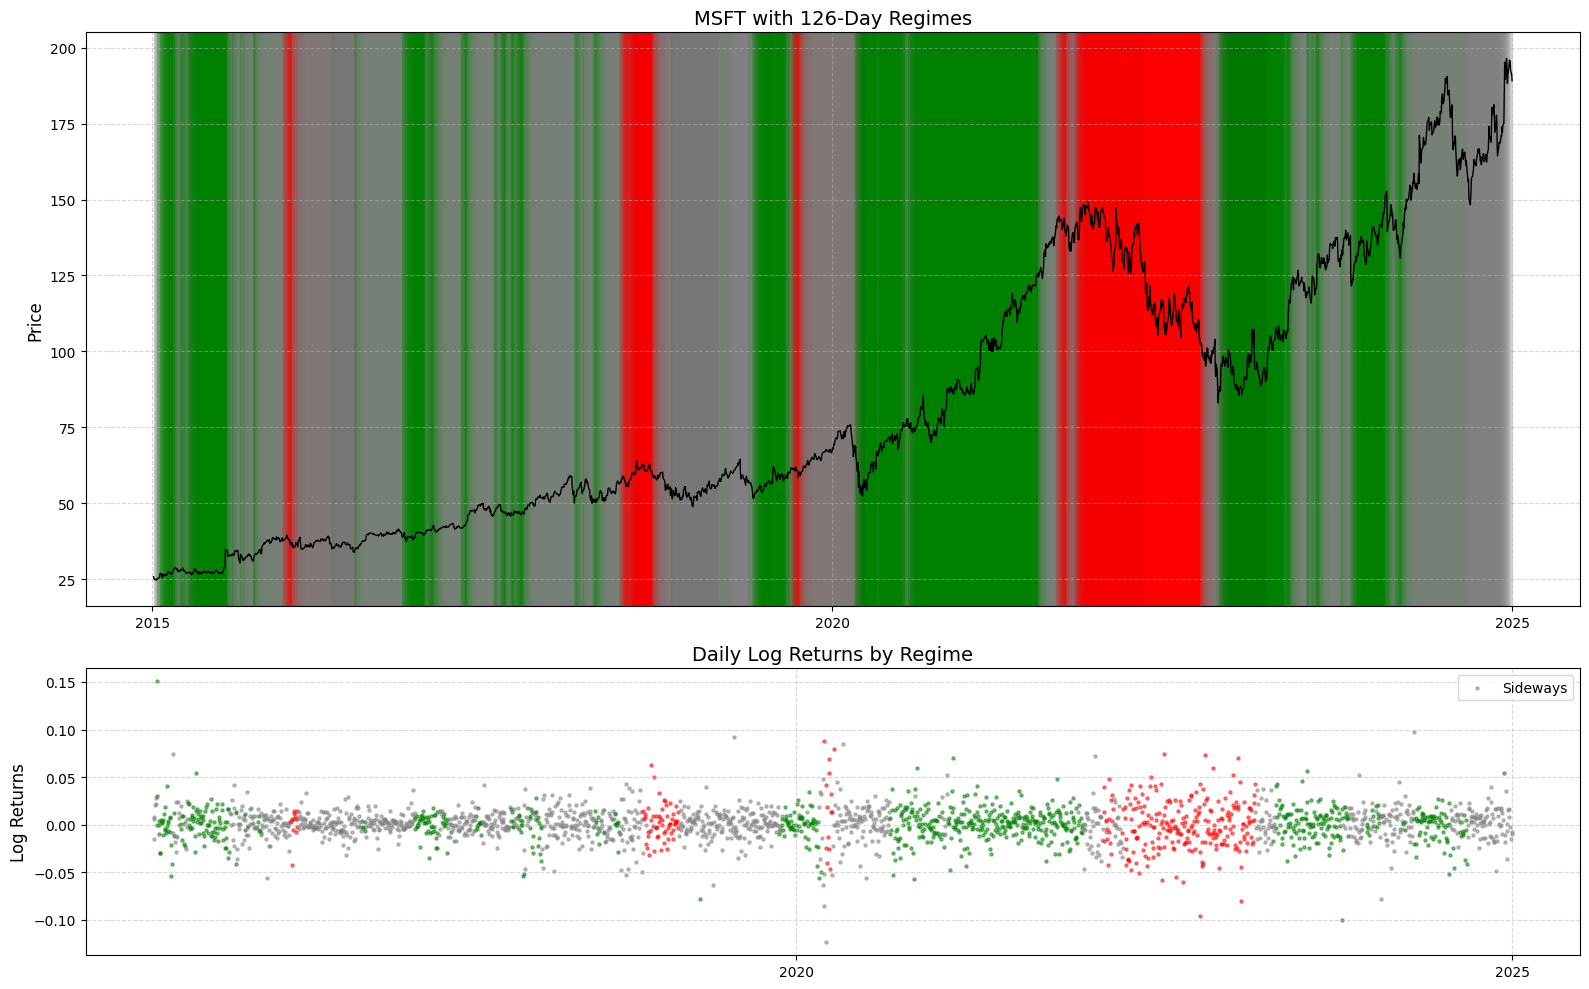

In [7]:
print("\nRunning enhanced regime detection...")
regime_labels, windows, _ = detect_regimes(data, window_size=126)
plot_regime_results(data, regime_labels, window_size=126)


In [10]:
print("\nRunning optimized hyperparameter study...")
param_results = hyperparameter_study(data,
    h1_options=[63, 126, 189],  
    h2_ratios=[0.3, 0.5],      
    n_runs=100)


Running optimized hyperparameter study...


Window Sizes: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]



Optimized Hyperparameter Results:
|   h1 | h2       |   1_year_median |   1_year_max |   1_year_max_inter |   1_year_avg_windows |   2_years_median |   2_years_max |   2_years_max_inter |   2_years_avg_windows |   20_years_median |   20_years_max_inter |
|-----:|:---------|----------------:|-------------:|-------------------:|---------------------:|-----------------:|--------------:|--------------------:|----------------------:|------------------:|---------------------:|
|   63 | 18 (30%) |            61   |         73.5 |                5.7 |                 10.5 |             55.8 |          65   |                 6.3 |                  24.5 |              47.9 |                  7.6 |
|   63 | 31 (50%) |            50.7 |         78.5 |                6.8 |                  6.1 |             55.7 |          73.1 |                 6.1 |                  14.2 |              54.3 |                  7.8 |
|  126 | 37 (30%) |            31.5 |         47.5 |                5.6 |        

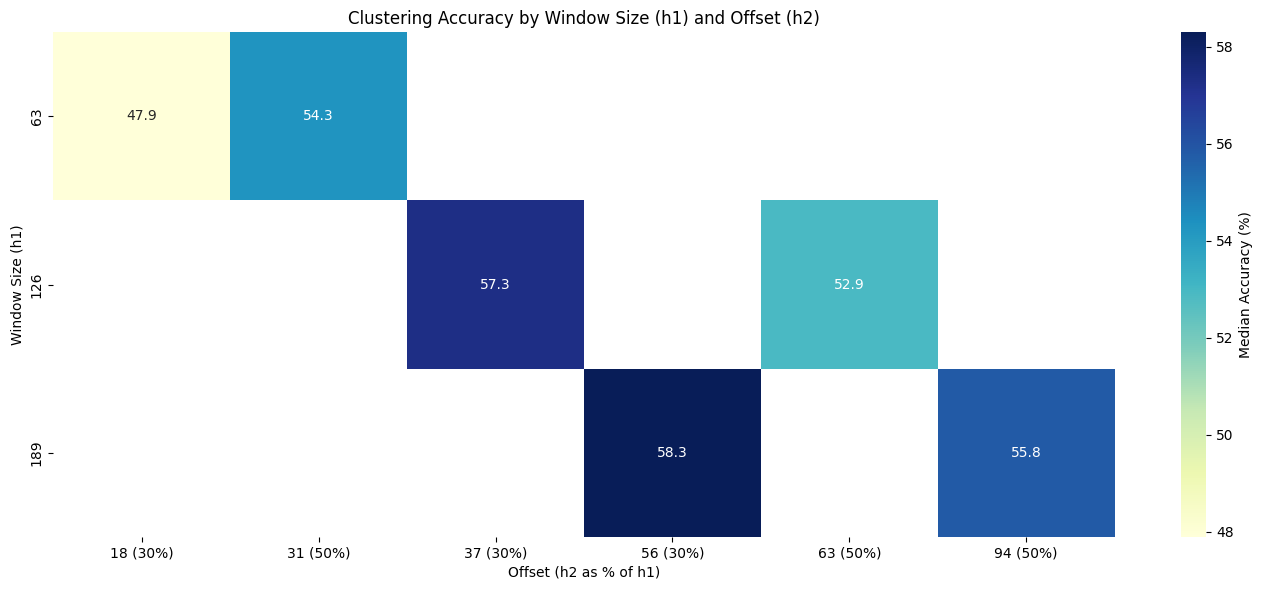


Enhanced analysis complete! Files saved:
- regimes_126days.png
- hyperparameter_heatmap.png
- hyperparameter_results.tex


In [15]:
final_table = param_results.round(1)
print("\nOptimized Hyperparameter Results:")
print(final_table.to_markdown(index=False))
final_table.to_html("hyperparameter_results.html", index=False)
plot_hyperparameter_results(final_table)
    
print("\nEnhanced analysis complete! Files saved:")
print("- regimes_126days.png")
print("- hyperparameter_heatmap.png")
print("- hyperparameter_results.tex")